<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/MaskFormer/Fine-tuning/Fine_tuning_MaskFormerForInstanceSegmentation_on_semantic_sidewalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune MaskFormer for semantic segmentation

In this notebook, we'll show how to fine-tune the model on a semantic segmentation dataset. In semantic segmentation, the goal for the model is to segment general semantic categories in an image, like "building", "people", "sky". No distinction is made between individual instances of a certain category, i.e. we just come up with one mask for the "people" category for instance, not for the individual persons.

Make sure to run this notebook on a GPU.

## Set-up environment

First, we install the necessary libraries. 🤗, what else? Oh yes we'll also use [Albumentations](https://albumentations.ai/), for some data augmentation to make the model more robust. You can of course use any data augmentation library of your choice.

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [3]:
!pip install -q datasets

In [4]:
!pip install -q albumentations

## Load data

Now let's the dataset from the hub.

"But how can I use my own dataset?" Glad you asked. I wrote a detailed guide for that [here](https://github.com/huggingface/transformers/tree/main/examples/pytorch/semantic-segmentation#note-on-custom-data).

In [5]:
from datasets import Dataset, DatasetDict, Image
import os

root = "/home/ubuntu/maskrcnn_training/dataset/coco-2017/"

image_paths_train = [os.path.join(root, "train/train_images", img_name) for img_name in os.listdir(os.path.join(root, "train/train_images"))]
label_paths_train = [os.path.join(root, "train/masks", img_name) for img_name in os.listdir(os.path.join(root, "train/masks"))]

# same for validation
image_paths_validation = [os.path.join(root, "validation/val_images", img_name) for img_name in os.listdir(os.path.join(root, "validation/val_images"))]
label_paths_validation = [os.path.join(root, "validation/masks", img_name) for img_name in os.listdir(os.path.join(root, "validation/masks"))]


/opt/conda/envs/maskformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
print(len(image_paths_train))
print(len(label_paths_train))
print(len(image_paths_validation))
print(len(label_paths_validation))
image_paths_train[0]

1734
1734
69
69


'/home/ubuntu/maskrcnn_training/dataset/coco-2017/train/train_images/000000456545.jpg'

In [7]:
import numpy as np
from PIL import Image as PILImage

def process_label(example):
    threshold = 255//2
    # Convert label image to numpy array
    label = np.array(example["label"])
    # Apply thresholding
    binary_label = np.where(label < threshold, 0, 1).astype(np.uint8)
    # Convert back to PIL Image
    binary_label_pil = PILImage.fromarray(binary_label)  # Scale to 0-255 for saving
    # Save the processed label image
    # binary_label_pil.save("processed_label.png")  # Update path dynamically if needed
    return {"binary_label": binary_label_pil}

In [8]:
def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())
    dataset = dataset.map(process_label)
    
    return dataset


In [9]:

# step 1: create Dataset objects
train_dataset = create_dataset(image_paths_train, label_paths_train)
validation_dataset = create_dataset(image_paths_validation, label_paths_validation)



Map:   0%|          | 0/1734 [00:00<?, ? examples/s]

Map: 100%|██████████| 69/69 [00:00<00:00, 328.43 examples/s]


In [13]:
print(type(train_dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
# step 2: create DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": validation_dataset,
  }
)

Let's take a look at this dataset in more detail. It consists of 1000 examples:

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'binary_label'],
        num_rows: 1734
    })
    validation: Dataset({
        features: ['image', 'label', 'binary_label'],
        num_rows: 69
    })
})

In [16]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

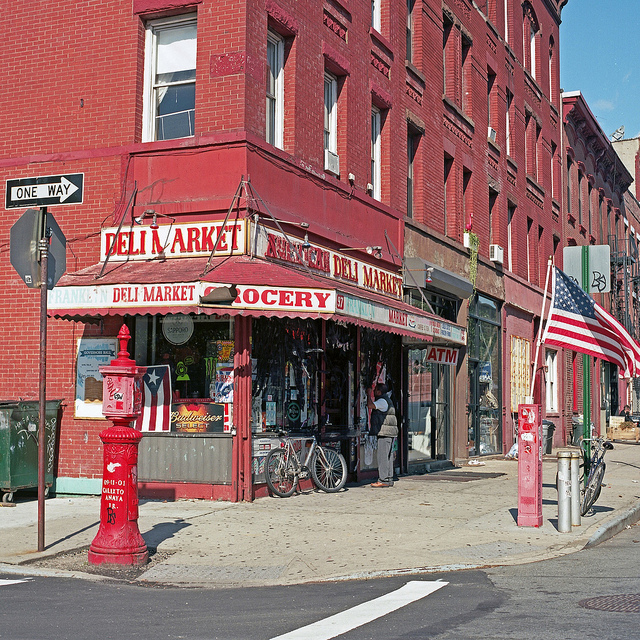

In [17]:
# let's look at one example (images are pretty high resolution)
example = train_ds[1]
image = example['image']
image

In [18]:
label = example['binary_label']
np.unique(label)


array([0, 1], dtype=uint8)

In [19]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
segmentation_map = np.array(example['binary_label'])
# threshold = 255 // 2
# segmentation_map = np.where(segmentation_map < threshold, 0, 1)
# print(np.unique(segmentation_map), segmentation_map.shape)


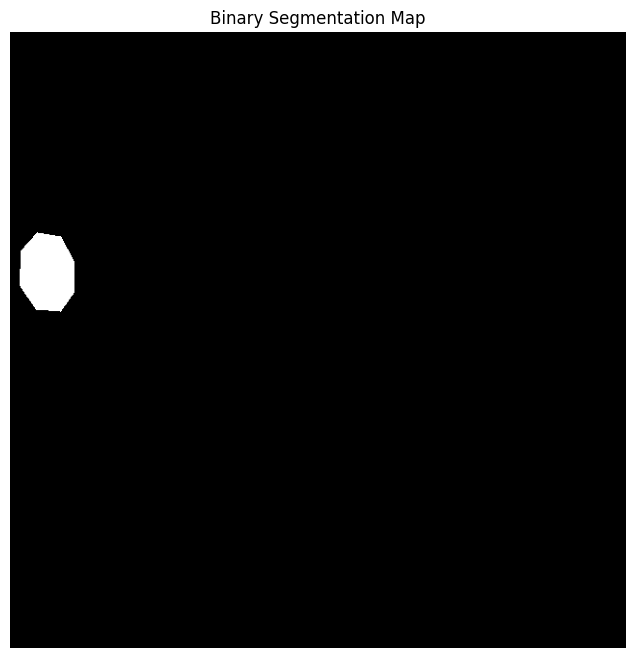

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(segmentation_map, cmap="gray")  # Display as a grayscale image
plt.title("Binary Segmentation Map")
plt.axis("off")
plt.show()

Let's look at the semantic categories in this particular example.

In [21]:
np.unique(segmentation_map)

array([0, 1], dtype=uint8)

Cool, but we want to know the actual class names. For that we need the id2label mapping, which is hosted in a repo on the hub.

In [16]:
import json

filename = "id2label.json"
with open(filename, "r") as file:
    id2label = json.load(file)
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'background', 1: 'stop_sign'}


In [23]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['background', 'stop_sign']


Let's visualize it:

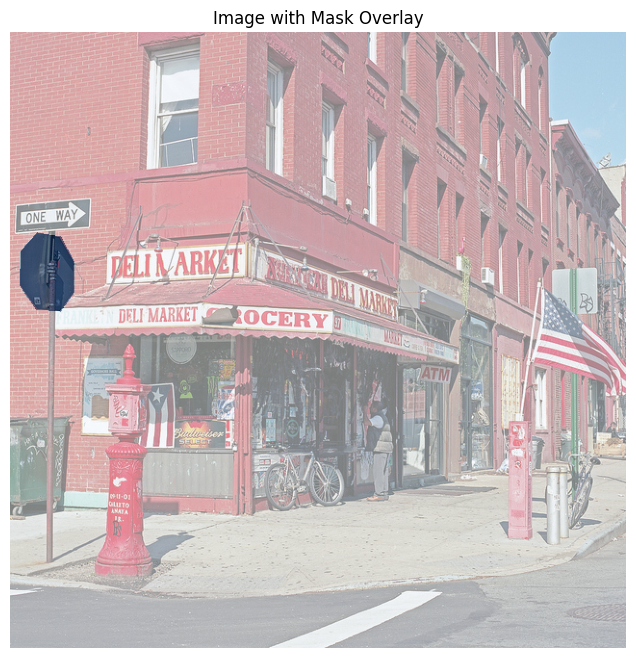

In [24]:
# Create an overlay with color for the segmentation map
image_np = np.array(image)
overlay = np.zeros_like(image_np, dtype=np.uint8)  # Same size as the image_np
overlay[segmentation_map == 1] = [0, 255, 0]  # Color the mask areas (e.g., red)

# Blend the overlay with the original image_np
alpha = 0.5  # Transparency factor
blended = image_np * (1 - alpha) + overlay * alpha
blended = blended.astype(np.uint8)

# Plot the original image_np and overlay
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_np)  # Display the image
ax.imshow(segmentation_map, cmap='Blues', alpha=0.5)  # Overlay the mask with transparency
ax.axis("off")
ax.set_title("Image with Mask Overlay")
# plt.figure(figsize=(10, 10))
# plt.imshow(blended)
# plt.title("Segmentation Map Overlay")
# plt.axis("off")
plt.show()

## Create PyTorch Dataset

Next, we create a standard PyTorch dataset. Each item of the dataset consists of the image and corresponding ground truth segmentation map. We also include the original image + map (before preprocessing) in order to compute metrics like mIoU.

In [25]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['image'])
        original_segmentation_map = np.array(self.dataset[idx]['binary_label'])
        
        if self.transform != None:
            transformed = self.transform(image=original_image, mask=original_segmentation_map)
            image, segmentation_map = transformed['image'], transformed['mask']
        else:
            image, segmentation_map = original_image, original_segmentation_map
        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

The dataset accepts image transformations which can be applied on both the image and the map. Here we use Albumentations, to resize, randomly crop + flip and normalize them. Data augmentation is a widely used technique in computer vision to make the model more robust.

In [ ]:
import albumentations as A

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])


# TODO: NORMALIZATION?

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1333),
    A.RandomCrop(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    # A.Normalize(mean=MEAN, std=STD),
])

test_transform = A.Compose([
    A.Resize(width=512, height=512),
    # A.Normalize(mean=MEAN, std=STD),
])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

In [27]:
img, segmentation_map, _, _ = train_dataset[0]
print(img.shape)
print(segmentation_map.shape)

(3, 640, 383)
(640, 383)


A great way to check that our data augmentations are working well is by denormalizing the pixel values. So here we perform the inverse operation of Albumentations' normalize method and visualize the image:

In [28]:
from PIL import Image

# unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
# unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
# unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
# img
# plt.show(img)
# img.shape

This looks ok. Let's also verify whether the corresponding ground truth map is still ok.

In [29]:
segmentation_map.shape


(640, 383)

In [30]:
id2label, np.unique(segmentation_map)

({0: 'background', 1: 'stop_sign'}, array([0, 1], dtype=uint8))

In [31]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['background', 'stop_sign']


In [32]:
img.shape

(3, 640, 383)

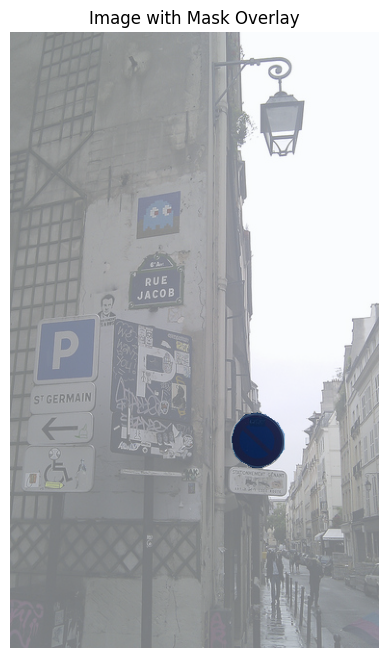

In [33]:
image_np = np.array(np.transpose(img, (1, 2, 0)) )
overlay = np.zeros_like(image_np, dtype=np.uint8)  # Same size as the image_np

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_np)  # Display the image
ax.imshow(segmentation_map, cmap='Blues', alpha=0.5)  # Overlay the mask with transparency
ax.axis("off")
ax.set_title("Image with Mask Overlay")
plt.show()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
# for label, color in enumerate(palette):
#     color_segmentation_map[segmentation_map == label, :] = color
# # Convert to BGR
# ground_truth_color_seg = color_segmentation_map[..., ::-1]

# img = np.moveaxis(image, 0, -1) * 0.5 + ground_truth_color_seg * 0.5
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.show()

Ok great!

## Create PyTorch DataLoaders

Next we create PyTorch DataLoaders, which allow us to get batches of the dataset. For that we define a custom so-called "collate function", which PyTorch allows you to do. It's in this function that we'll use the preprocessor of MaskFormer, to turn the images + maps into the format that MaskFormer expects.

It's here that we make the paradigm shift that the MaskFormer authors introduced: the "per-pixel" annotations of the segmentation map will be turned into a set of binary masks and corresponding labels. It's this format on which we can train MaskFormer. MaskFormer namely casts any image segmentation task to this format.

In [34]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=True, do_rescale=False, do_normalize=True)

In [35]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]
    
    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

## Verify data (!!)

Next, it's ALWAYS very important to check whether the data you feed to the model actually makes sense. It's one of the main principles of [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/), if you wanna debug your neural networks.

Let's check the first batch, and its content.

In [36]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 800, 1216])
pixel_mask torch.Size([2, 800, 1216])
mask_labels torch.Size([1, 800, 1216])
class_labels torch.Size([1])
original_images (427, 640, 3)
original_segmentation_maps (427, 640)


In [37]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 800, 1216)

Let's verify the corresponding binary masks + class labels.

In [38]:
# verify class labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['stop_sign']


In [39]:
# verify mask labels
batch["mask_labels"][0].shape

torch.Size([1, 800, 1216])

In [40]:
def visualize_mask(labels, label_name):
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: stop_sign


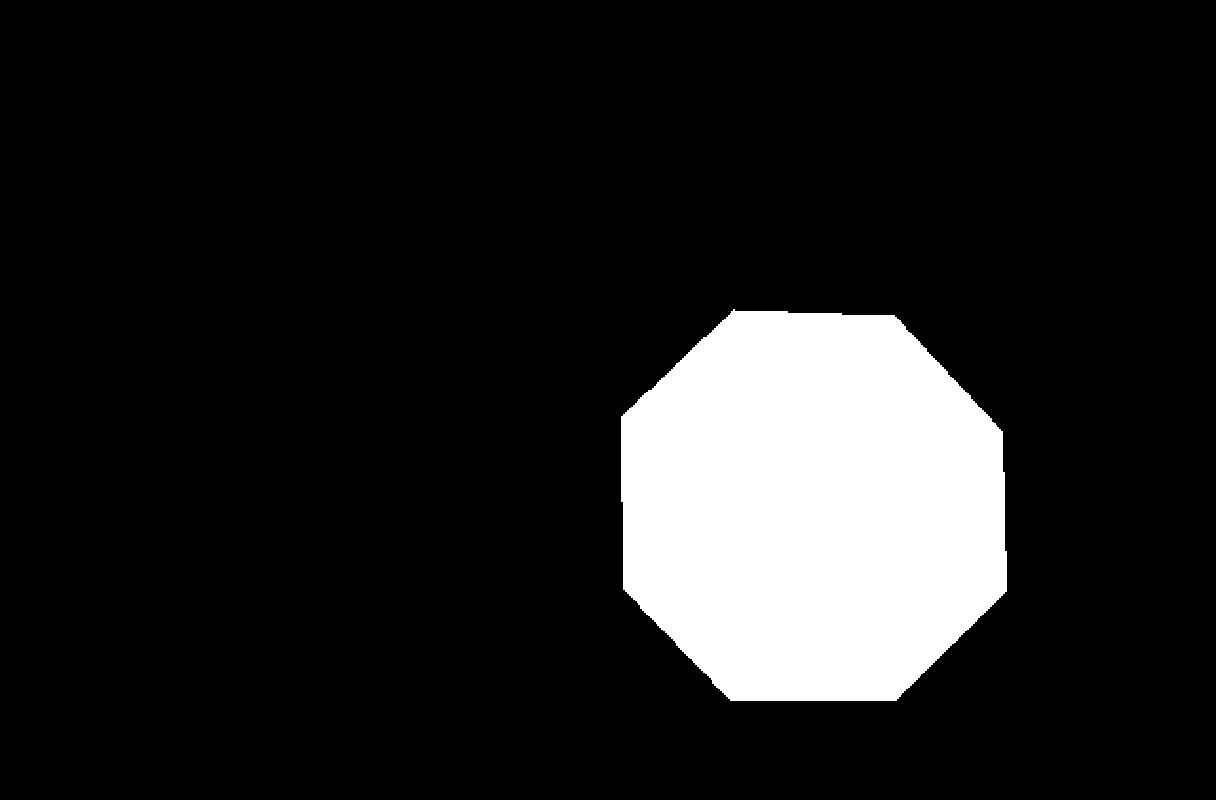

In [41]:
visualize_mask(labels, "stop_sign")

## Define model

Next, we define the model. We equip the model with pretrained weights from the 🤗 hub. We will replace only the classification head. For that we provide the id2label mapping, and specify to ignore mismatches keys to replace the already fine-tuned classification head.

In [42]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


See also the warning here: it's telling us that we are only replacing the class_predictor, which makes sense. As it's the only parameters that we will train from scratch.

## Compute initial loss

Another good way to debug neural networks is to verify the initial loss, see if it makes sense.

In [ ]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])

In [ ]:
outputs.loss

## Train the model

It's time to train the model! We'll use the mIoU metric to track progress.

In [ ]:
!pip install -q evaluate

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(100):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 5:
      break

    pixel_values = batch["pixel_values"]
    
    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)
  
  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of a test batch.

In [17]:
from transformers import MaskFormerForInstanceSegmentation
model = MaskFormerForInstanceSegmentation.from_pretrained("trained_models",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Backbone maskformer-swin is not a supported model and may not be compatible with MaskFormer. Supported model types: resnet,swin
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at trained_models and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from PIL import Image
image = Image.open("/home/ubuntu/maskrcnn_training/dataset/coco-2017/validation/data/000000015440.jpg")

from transformers import MaskFormerImageProcessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=True, do_rescale=False, do_normalize=True)
inputs = preprocessor(image, return_tensors="pt")
# forward pass
outputs = model(**inputs)

In [22]:
outputs.keys()

odict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])

In [28]:
outputs['class_queries_logits'].shape

torch.Size([1, 100, 3])

In [29]:
target_sizes = [(np.array(image).shape[0], np.array(image).shape[1])]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

In [39]:
sum(predicted_segmentation_maps).unique()

tensor([0])

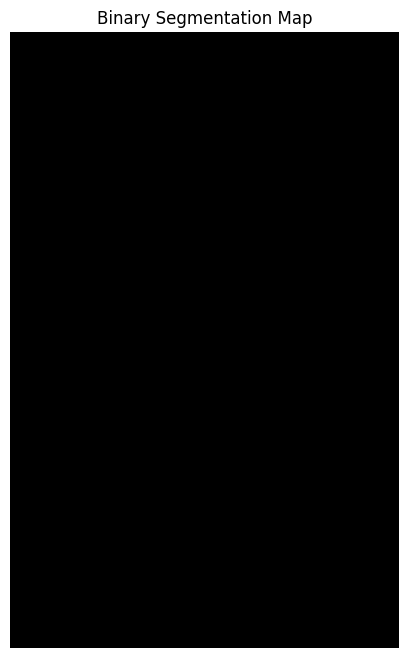

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(segmentation_map, cmap="gray")  # Display as a grayscale image
plt.title("Binary Segmentation Map")
plt.axis("off")
plt.show()

In [ ]:
# let's take the first test batch
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

In [ ]:
# forward pass
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [ ]:
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

In [ ]:
image = batch["original_images"][0]
Image.fromarray(image)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare to the ground truth:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = batch["original_segmentation_maps"][0]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()